In [2]:
!pip install /Users/hc/Documents/flexxy/flexynesis-mps/dist/flexynesis_mps-1.0.8-py3-none-any.whl
import os
import flexynesis
import torch
import numpy as np
import seaborn as sns
import pandas as pd
import random
import lightning as pl

# Set PyTorch thread count and check MPS availability
torch.set_num_threads(4)
print('MPS available:', torch.backends.mps.is_available())

Processing /Users/hc/Documents/flexxy/flexynesis-mps/dist/flexynesis_mps-1.0.8-py3-none-any.whl
  Using cached matplotlib-3.9.4-cp39-cp39-macosx_11_0_arm64.whl.metadata (11 kB)
  Using cached matplotlib-3.9.4-cp39-cp39-macosx_11_0_arm64.whl.metadata (11 kB)
  Using cached numpy-2.0.2-cp39-cp39-macosx_14_0_arm64.whl.metadata (60 kB)
  Using cached numpy-2.0.2-cp39-cp39-macosx_14_0_arm64.whl.metadata (60 kB)
  Using cached pandas-2.3.2-cp39-cp39-macosx_11_0_arm64.whl.metadata (91 kB)
  Using cached pandas-2.3.2-cp39-cp39-macosx_11_0_arm64.whl.metadata (91 kB)
  Using cached lightning-2.5.4-py3-none-any.whl.metadata (39 kB)
  Using cached lightning-2.5.4-py3-none-any.whl.metadata (39 kB)
  Using cached PyYAML-6.0.2-cp39-cp39-macosx_11_0_arm64.whl.metadata (2.1 kB)
  Using cached PyYAML-6.0.2-cp39-cp39-macosx_11_0_arm64.whl.metadata (2.1 kB)
  Using cached scikit_optimize-0.10.2-py2.py3-none-any.whl.metadata (9.7 kB)
  Using cached scikit_optimize-0.10.2-py2.py3-none-any.whl.metadata (9.7 

In [4]:
if not os.path.exists("lgggbm_tcga_pub_processed"):
    # Download the dataset archive if not present
    !curl -O "https://bimsbstatic.mdc-berlin.de/akalin/buyar/flexynesis-benchmark-datasets/lgggbm_tcga_pub_processed.tgz"
    # Extract the archive
    !tar -xzvf lgggbm_tcga_pub_processed.tgz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1775k  100 1775k    0     0  1622k      0  0:00:01  0:00:01 --:--:-- 1624k
100 1775k  100 1775k    0     0  1622k      0  0:00:01  0:00:01 --:--:-- 1624k
x lgggbm_tcga_pub_processed/
x lgggbm_tcga_pub_processed/train/
x lgggbm_tcga_pub_processed/train/mut.csv
x lgggbm_tcga_pub_processed/train/cna.csv
x lgggbm_tcga_pub_processed/train/clin.csv
x lgggbm_tcga_pub_processed/test/
x lgggbm_tcga_pub_processed/test/mut.csv
x lgggbm_tcga_pub_processed/test/cna.csv
x lgggbm_tcga_pub_processed/test/clin.csv
x lgggbm_tcga_pub_processed/
x lgggbm_tcga_pub_processed/train/
x lgggbm_tcga_pub_processed/train/mut.csv
x lgggbm_tcga_pub_processed/train/cna.csv
x lgggbm_tcga_pub_processed/train/clin.csv
x lgggbm_tcga_pub_processed/test/
x lgggbm_tcga_pub_processed/test/mut.csv
x lgggbm_tcga_pub_processed/test/cna.csv
x lgggbm_tcga_pub_processed/

## Importing Train and Test Datasets

We import train and test datasets including mutations and copy number alterations. We rank genes by Laplacian Scores and pick top 10% of the genes, while removing highly redundant genes with a correlation score threshold of 0.8 and a variance threshold of 50%. By setting `concatenate` to `False`, we will be doing an `intermediate` fusion of omic layers. 

In [5]:
data_importer = flexynesis.data.DataImporter(path ='./lgggbm_tcga_pub_processed/', 
                                        data_types = ['mut', 'cna'], log_transform=False, 
                                        concatenate=False, top_percentile=10, min_features=1000, correlation_threshold=0.8, 
                                       variance_threshold=0.5)
train_dataset, test_dataset = data_importer.import_data()

/Users/hc/Documents/flexxy/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(



[INFO] ================= Importing Data =================
[INFO] Validating data folders...

[INFO] ----------------- Reading Data ----------------- 
[INFO] Importing ./lgggbm_tcga_pub_processed/train/mut.csv...
[INFO] Importing ./lgggbm_tcga_pub_processed/train/clin.csv...
[INFO] Importing ./lgggbm_tcga_pub_processed/train/cna.csv...

[INFO] ----------------- Reading Data ----------------- 
[INFO] Importing ./lgggbm_tcga_pub_processed/test/mut.csv...
[INFO] Importing ./lgggbm_tcga_pub_processed/test/clin.csv...
[INFO] Importing ./lgggbm_tcga_pub_processed/test/cna.csv...

[INFO] ----------------- Reading Data ----------------- 
[INFO] Importing ./lgggbm_tcga_pub_processed/test/mut.csv...
[INFO] Importing ./lgggbm_tcga_pub_processed/test/clin.csv...
[INFO] Importing ./lgggbm_tcga_pub_processed/test/cna.csv...

[INFO] ----------------- Checking for problems with the input data ----------------- 
[INFO] Data structure is valid with no errors or warnings.

[INFO] ----------------- Proces

Filtering redundant features: 100%|██████████| 1000/1000 [00:00<00:00, 21222.80it/s]



[INFO] Implementing feature selection using laplacian score for layer: cna with  12376 features  and  556  samples 


Filtering redundant features: 100%|██████████| 1237/1237 [00:00<00:00, 339485.31it/s]




[INFO] ----------------- Processing Data (test) ----------------- 

[INFO] ----------------- Cleaning Up Data ----------------- 

[INFO] working on layer:  mut
[INFO] Number of NA values:  0
[INFO] DataFrame mut - Removed 0 features.

[INFO] working on layer:  cna
[INFO] Number of NA values:  0
[INFO] DataFrame cna - Removed 12370 features.
[INFO] DataFrame mut - Removed 0 samples (0.00%).
[INFO] DataFrame cna - Removed 0 samples (0.00%).

[INFO] ----------------- Harmonizing Data Sets ----------------- 

[INFO] ----------------- Finished Harmonizing ----------------- 

[INFO] ----------------- Normalizing Data ----------------- 

[INFO] ----------------- Normalizing Data ----------------- 
[INFO] Training Data Stats:  {'feature_count in: mut': 1000, 'feature_count in: cna': 1237, 'sample_count': 556}
[INFO] Test Data Stats:  {'feature_count in: mut': 1000, 'feature_count in: cna': 1237, 'sample_count': 238}
[INFO] Merging Feature Logs...
[INFO] Data import successful.


## 1. Exploratory Data Analysis 

Before building any machine learning models on the data, it is important to first familiarize yourself with the data you are working with. 
It is important to know the available data matrices, their sizes/shapes, available clinical variables and how they are distributed. 

Below you are asked to do simple explorations of the available data. 

## 1.1 Print the shapes of the available data matrices 

- How many features and samples are available per data type in train/test datasets? 

In [4]:
[train_dataset.dat[x].shape for x in train_dataset.dat.keys()]

[torch.Size([556, 1000]), torch.Size([556, 1237])]

In [5]:
[test_dataset.dat[x].shape for x in test_dataset.dat.keys()]

[torch.Size([238, 1000]), torch.Size([238, 1237])]

## 1.2 Explore sample annotations 

- What are the available clinical variables? Are they available in both train and test datasets? (See <dataset>.ann)  

In [6]:
train_dataset.ann.keys(), test_dataset.ann.keys()

(dict_keys(['AGE', 'OS_MONTHS', 'OS_STATUS', 'KARNOFSKY_PERFORMANCE_SCORE', 'STUDY', 'BCR_STATUS', 'HISTOLOGICAL_DIAGNOSIS', 'SEX']),
 dict_keys(['AGE', 'OS_MONTHS', 'OS_STATUS', 'KARNOFSKY_PERFORMANCE_SCORE', 'STUDY', 'BCR_STATUS', 'HISTOLOGICAL_DIAGNOSIS', 'SEX']))

- Make a histogram plot of the follow up times in months (OS_MONTHS) (use sns.histplot)

<Axes: ylabel='Count'>

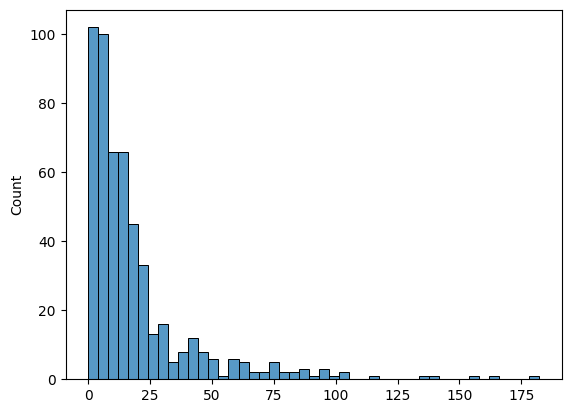

In [7]:
sns.histplot(train_dataset.ann['OS_MONTHS'])

- Make a ~~histogram~~ boxplot of the age distribution of the patients in the training data; facet the histogram by "SEX" variable (see flexynesis.utils.plot_boxplot)

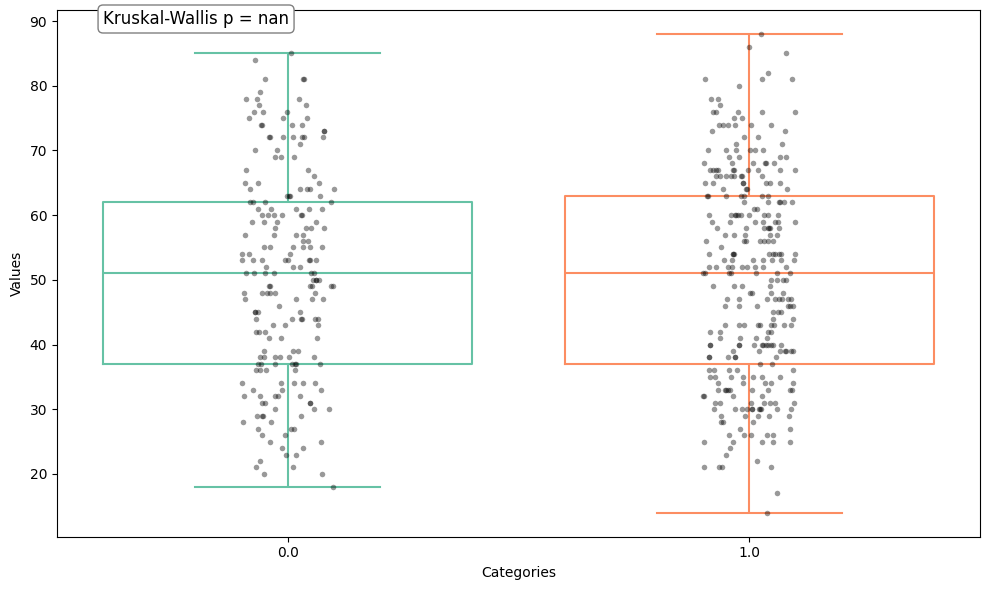

In [8]:
flexynesis.utils.plot_boxplot(train_dataset.ann['SEX'], train_dataset.ann['AGE'])

- Make a summary of all available clinical variables (see flexynesis.print_summary_stats)

In [9]:
flexynesis.utils.print_summary_stats(train_dataset)

Summary for variable: AGE
Numerical Variable Summary: Median = 51.0, Mean = 50.33781051635742
------
Summary for variable: OS_MONTHS
Numerical Variable Summary: Median = 11.600000381469727, Mean = 19.090980529785156
------
Summary for variable: OS_STATUS
Numerical Variable Summary: Median = 0.0, Mean = 0.36153846979141235
------
Summary for variable: KARNOFSKY_PERFORMANCE_SCORE
Numerical Variable Summary: Median = 80.0, Mean = 82.45454406738281
------
Summary for variable: STUDY
Categorical Variable Summary:
  Label: Brain Lower Grade Glioma, Count: 353
  Label: Glioblastoma multiforme, Count: 203
------
Summary for variable: BCR_STATUS
Categorical Variable Summary:
  Label: IGC, Count: 454
  Label: NCH, Count: 102
------
Summary for variable: HISTOLOGICAL_DIAGNOSIS
Categorical Variable Summary:
  Label: astrocytoma, Count: 115
  Label: glioblastoma, Count: 201
  Label: oligoastrocytoma, Count: 79
  Label: oligodendroglioma, Count: 126
  Label: nan, Count: 35
------
Summary for variabl

- Notice that the categorical variables such as "SEX", "STUDY", "HISTOLOGICAL_DIAGNOSIS" are encoded numerically in the "dataset.ann" objects. Use dataset.label_mappings to map the STUDY variable to their original labels. 
Print the top 10 values in dataset.ann['STUDY'] and the mapped label values. 

In [10]:
study_labels = [train_dataset.label_mappings['STUDY'][x] for x in train_dataset.ann['STUDY'].cpu().numpy()]

In [11]:
train_dataset.ann['STUDY'][0:10],  study_labels[0:10]

(tensor([0., 1., 0., 1., 1., 0., 0., 0., 0., 0.]),
 ['Brain Lower Grade Glioma',
  'Glioblastoma multiforme',
  'Brain Lower Grade Glioma',
  'Glioblastoma multiforme',
  'Glioblastoma multiforme',
  'Brain Lower Grade Glioma',
  'Brain Lower Grade Glioma',
  'Brain Lower Grade Glioma',
  'Brain Lower Grade Glioma',
  'Brain Lower Grade Glioma'])

- Now, let's explore the data matrices. Make a PCA plot of the mutation data matrix and color the samples by "HISTOLOGICAL_DIAGNOSIS". See flexynesis.plot_dim_reduced function

First create a pandas data frame with the data matrix of interest with feature and sample names 
> df = pd.DataFrame(train_dataset.dat['cna'], index = train_dataset.samples, columns= train_dataset.features['cna'])

Check the data frame contents 
> df.head()

Make a PCA plot of CNA values using the labels from the STUDY variable 

**Note**: if you couldn't map the labels above, you can also use ~~train_dataset.dat['STUDY']~~ train_dataset.ann['STUDY'] as labels  

In [12]:
df = pd.DataFrame(train_dataset.dat['cna'], index = train_dataset.samples, columns= train_dataset.features['cna'])

In [13]:
df.head()

,SLC30A8,ZNF273,OR9A1P,AGL,KCNA5,MIR603,SNTB1,MRPL13,MTBP,SNORA72|ENSG00000252158.1,...,CAV1,FZD1,ADAM22,BCAP29,MNX1,LRP8,NOM1,RN7SL290P,CPA5,CPA1
TCGA-DH-A7UU,-0.175212,-0.741551,-0.844373,0.375758,-0.249638,3.865423,-0.182855,-0.182698,-0.182698,-0.185710,...,-0.848445,-0.795174,-0.772615,-0.848738,-0.825275,0.378765,-0.825457,0.388252,-0.866199,-0.866199
TCGA-06-0142,-0.277810,-0.556645,-0.683469,0.402920,-0.209740,0.328969,-0.287094,-0.286934,-0.286934,-0.289404,...,-0.687500,-0.619655,-0.606400,-0.668159,-0.666120,0.419521,-0.666308,0.429423,-0.707921,-0.707921
TCGA-E1-A7Z2,-0.264657,0.634737,-0.878366,0.383907,-0.188461,-1.083819,-0.273730,-0.273571,-0.273571,-0.276110,...,-0.841644,-0.837388,-0.812590,0.717041,-0.903732,0.400502,-0.903911,0.410210,0.680913,0.680913
TCGA-74-6584,-0.540882,0.277533,0.540304,0.739728,-0.260278,-0.821444,-0.554373,-0.554208,-0.554208,-0.555285,...,0.536585,2.459721,6.900600,0.547891,0.544355,0.816206,0.544127,0.830145,0.495884,0.495884
TCGA-06-0168,-0.301487,0.800732,0.841715,2.325985,-0.193781,-1.045696,-0.311149,-0.310989,-0.310989,-0.313333,...,0.838073,0.815610,0.752771,0.808473,0.842490,2.343172,0.842253,2.372650,0.792377,0.792377


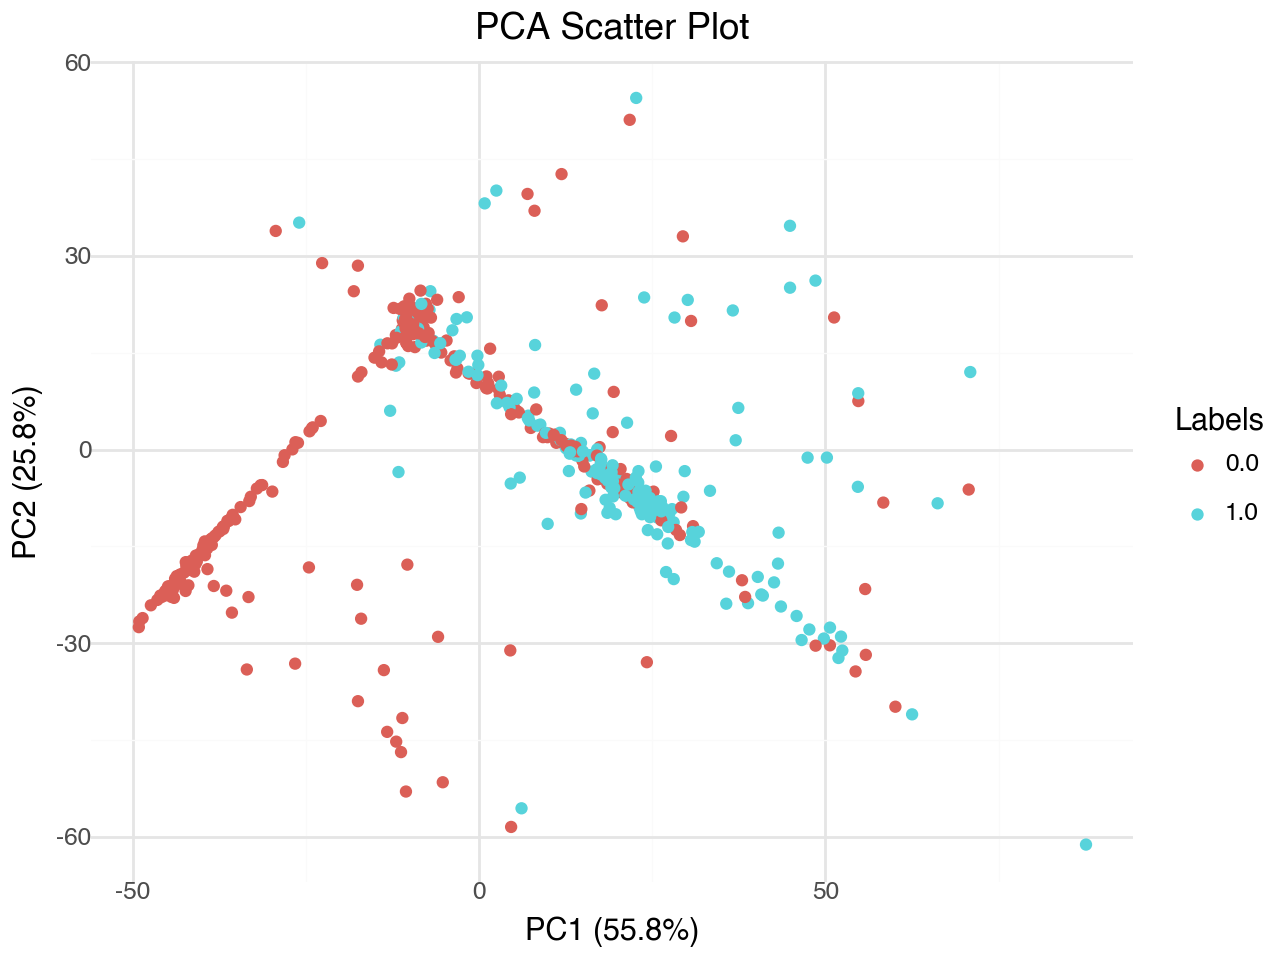

In [14]:
flexynesis.utils.plot_dim_reduced(df, train_dataset.ann['STUDY'])

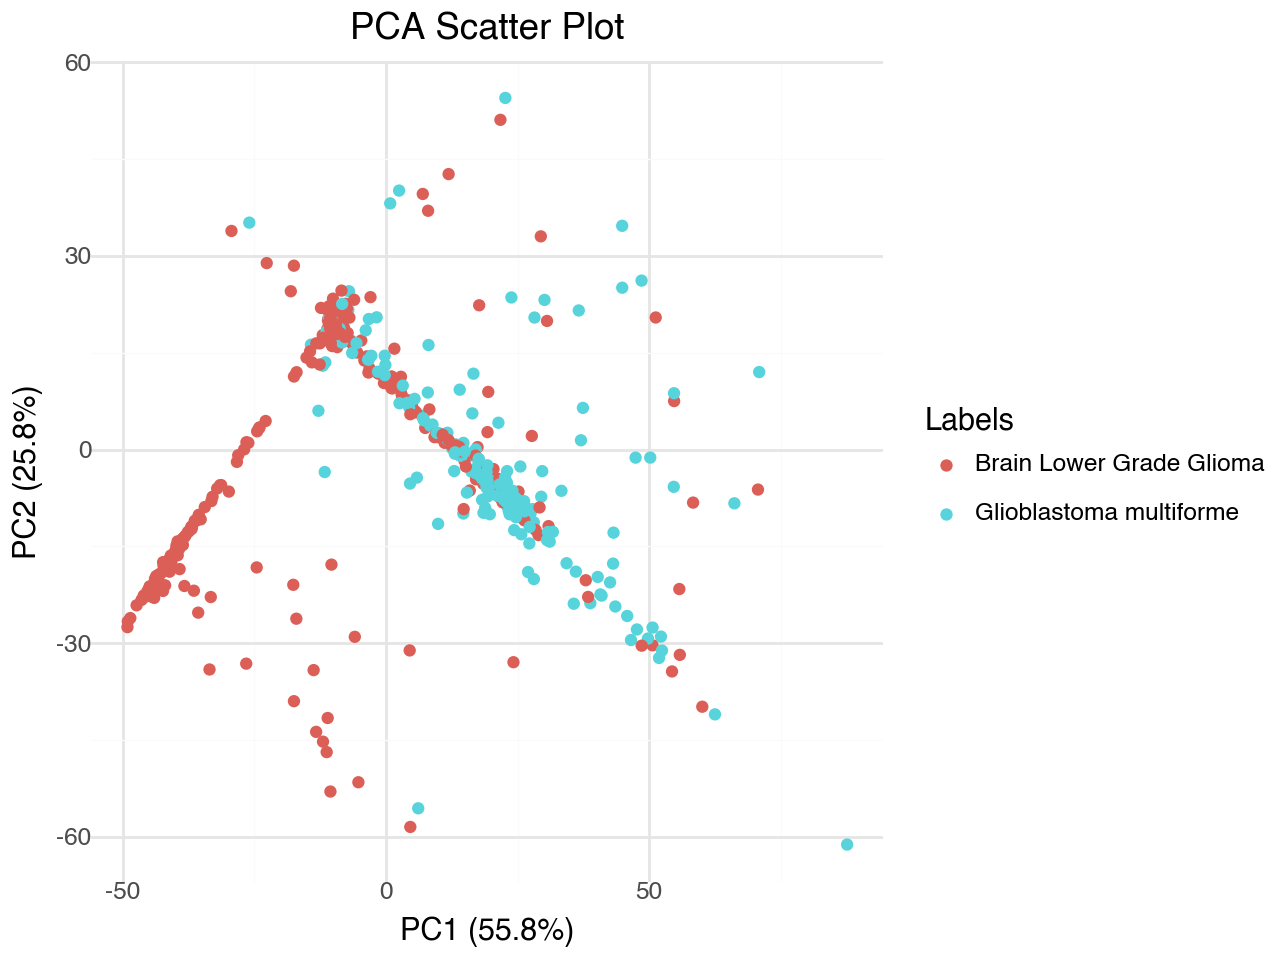

In [15]:
flexynesis.utils.plot_dim_reduced(df, study_labels)

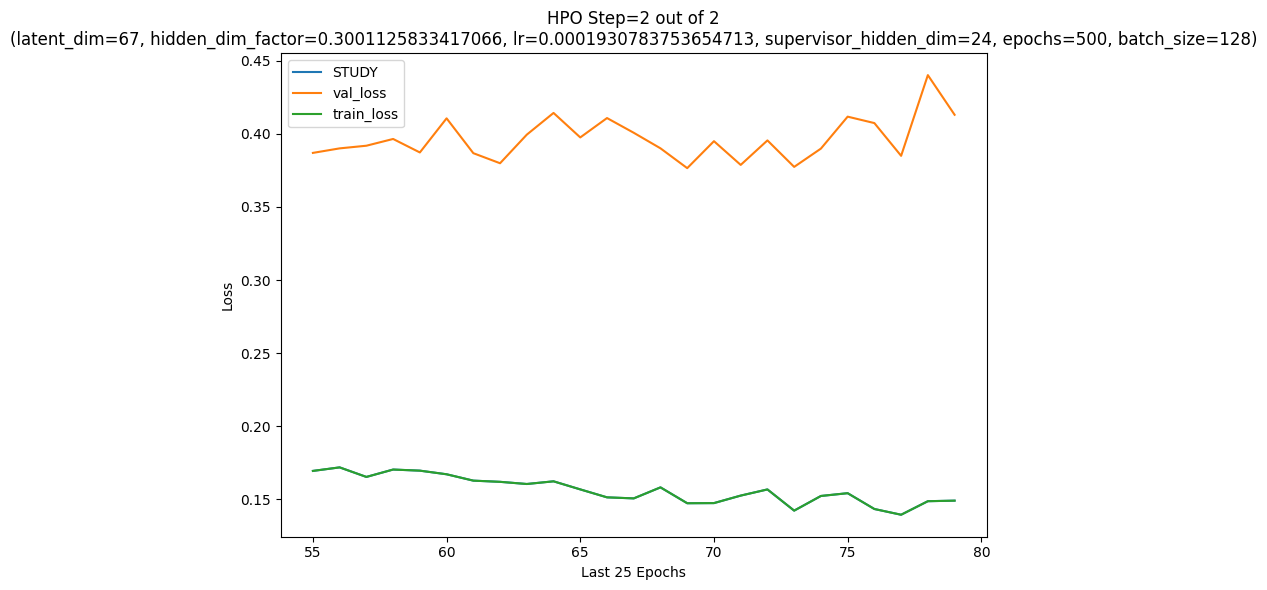

Validation: |          | 0/? [00:00<?, ?it/s]

/Users/hc/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/hc/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           STUDY           │     0.412977010011673     │
│         val_loss          │     0.412977010011673     │
└───────────────────────────┴───────────────────────────┘

Tuning Progress: 100%|██████████| 2/2 [01:14<00:00, 37.15s/it, Iteration=2, Best Loss=0.389]

[INFO] current best val loss: 0.3894502818584442; best params: {'latent_dim': 105, 'hidden_dim_factor': 0.25503043695984917, 'lr': 0.00362561763457623, 'supervisor_hidden_dim': 22, 'epochs': 500, 'batch_size': 32} since 1 hpo iterations


In [16]:
# Define a tuner; See n_iter is the number of 
tuner = flexynesis.main.HyperparameterTuning(train_dataset, 
                                        model_class = flexynesis.models.DirectPred, 
                                        config_name = "DirectPred",
                                        target_variables = ['STUDY'], 
                                        n_iter=2, 
                                        plot_losses=True, 
                                        early_stop_patience=10)
### Perform Training 
model, best_params = tuner.perform_tuning()

In [17]:
model

DirectPred(
  (log_vars): ParameterDict(  (STUDY): Parameter containing: [torch.FloatTensor of size 1])
  (encoders): ModuleList(
    (0): MLP(
      (layer_1): Linear(in_features=1000, out_features=255, bias=True)
      (layer_out): Linear(in_features=255, out_features=105, bias=True)
      (relu): ReLU()
      (dropout): Dropout(p=0.1, inplace=False)
      (batchnorm): BatchNorm1d(255, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): MLP(
      (layer_1): Linear(in_features=1237, out_features=315, bias=True)
      (layer_out): Linear(in_features=315, out_features=105, bias=True)
      (relu): ReLU()
      (dropout): Dropout(p=0.1, inplace=False)
      (batchnorm): BatchNorm1d(315, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (fusion_block): Linear(in_features=210, out_features=105, bias=True)
  (MLPs): ModuleDict(
    (STUDY): MLP(
      (layer_1): Linear(in_features=105, out_features=22, bias=True)
      (layer_out): Linea

In [18]:
## See which hyperparameter combination was the best 
best_params

{'latent_dim': 105,
 'hidden_dim_factor': 0.25503043695984917,
 'lr': 0.00362561763457623,
 'supervisor_hidden_dim': 22,
 'epochs': 24,
 'batch_size': 32}

In [19]:
## Evaluate the model and visualising the results
flexynesis.utils.evaluate_wrapper(method = 'DirectPred', y_pred_dict=model.predict(test_dataset), dataset = test_dataset)                            

,method,var,variable_type,metric,value
0,DirectPred,STUDY,categorical,balanced_acc,0.798039
1,DirectPred,STUDY,categorical,f1_score,0.824761
2,DirectPred,STUDY,categorical,kappa,0.613728
3,DirectPred,STUDY,categorical,average_auroc,0.893041
4,DirectPred,STUDY,categorical,average_aupr,0.764754


Let's extract the sample embeddings and make a PCA plot and color by the target variable 

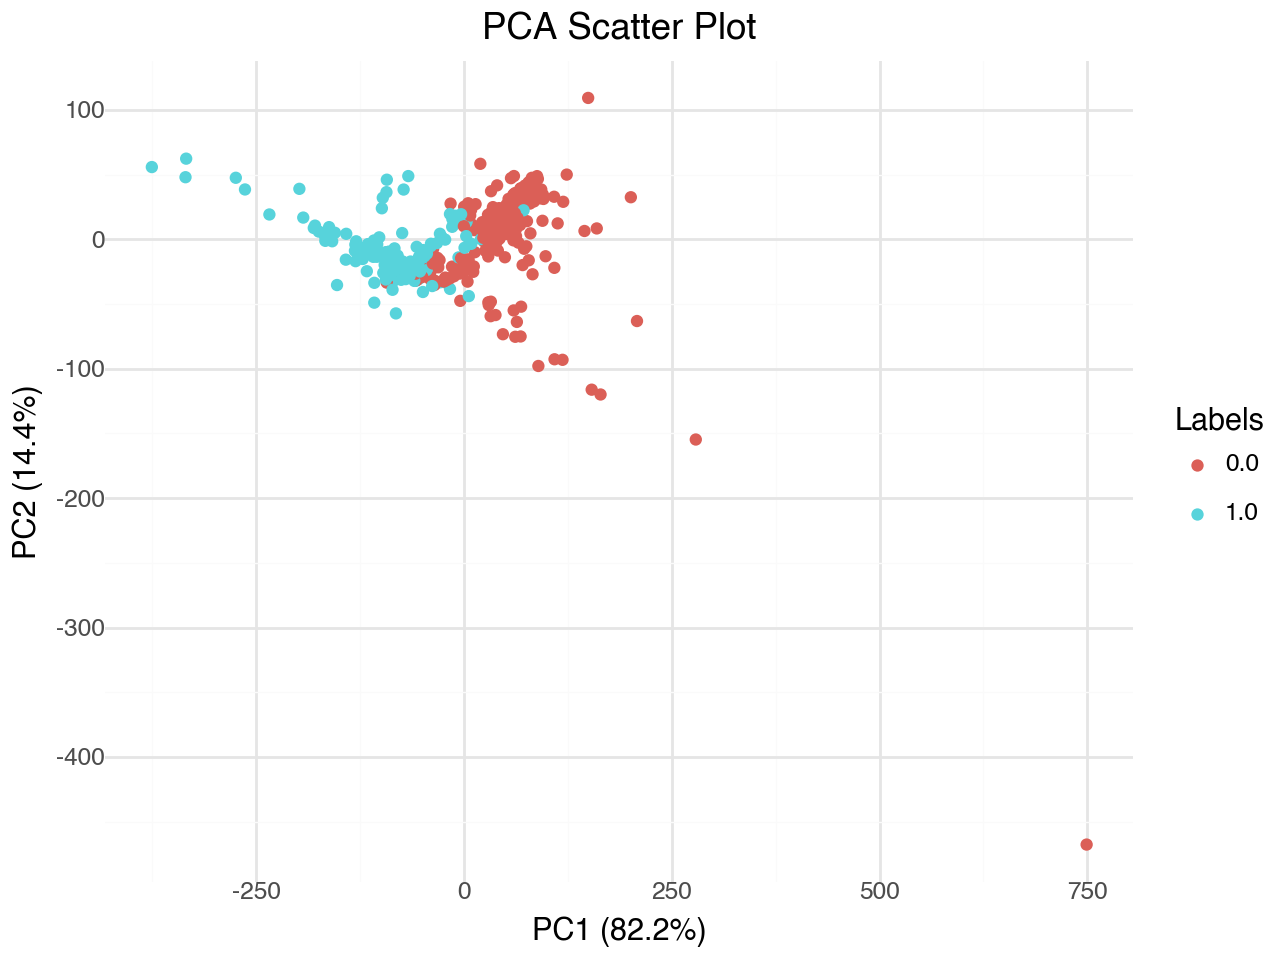

In [20]:
train_embeddings = model.transform(train_dataset)
flexynesis.utils.plot_dim_reduced(train_embeddings, train_dataset.ann['STUDY'])

Repeat the same for the test dataset: extract sample embeddings for test dataset samples and make a PCA plot, colored by "STUDY" variable 

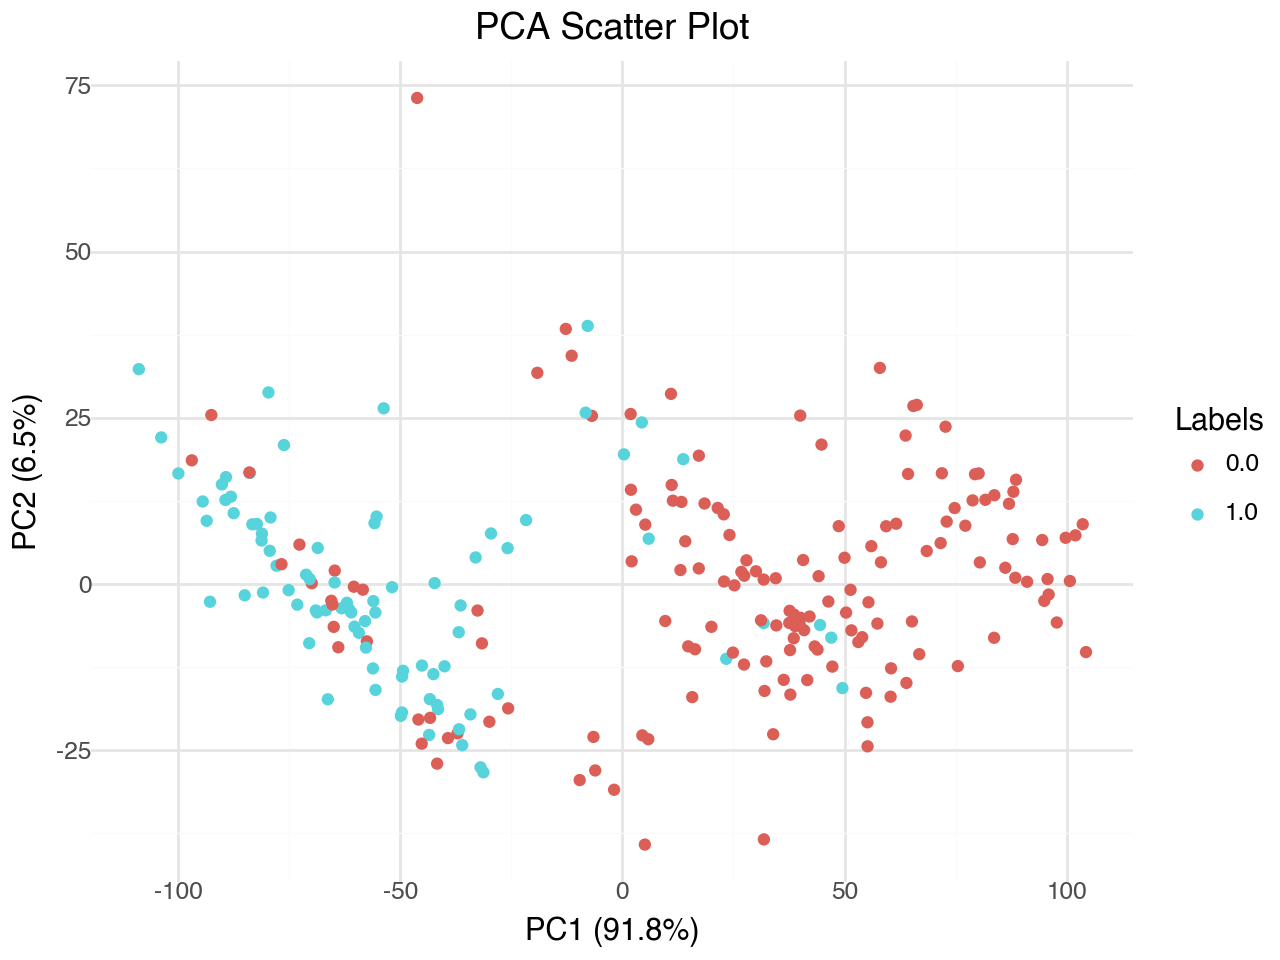

In [21]:
test_embeddings = model.transform(test_dataset)
flexynesis.utils.plot_dim_reduced(test_embeddings, test_dataset.ann['STUDY'])

## 3.1 Exercises

**Exercise 1**:

Now, you build a model using hyperparameter tuning (run at least 10 HPO steps) to predict the survival outcomes of patients. 
Evaluate the final model on test dataset, which computes the "C-index". 

Feel free to cheat from the tutorial available here: https://github.com/BIMSBbioinfo/flexynesis/blob/main/examples/tutorials/survival_subtypes_LGG_GBM.ipynb
See how "OS_STATUS" and "OS_MONTHS" were used. 

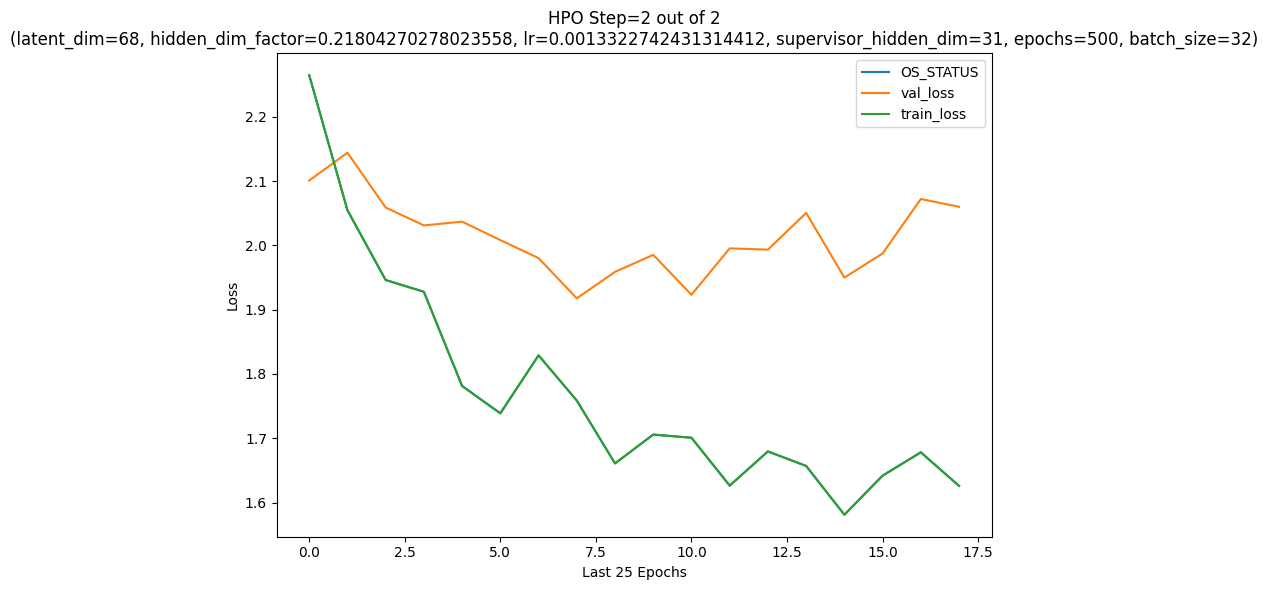

Validation: |          | 0/? [00:00<?, ?it/s]

/Users/hc/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/hc/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         OS_STATUS         │     2.059918165206909     │
│         val_loss          │     2.059918165206909     │
└───────────────────────────┴───────────────────────────┘

Tuning Progress: 100%|██████████| 2/2 [00:48<00:00, 24.26s/it, Iteration=2, Best Loss=2.06]

[INFO] current best val loss: 2.059918165206909; best params: {'latent_dim': 68, 'hidden_dim_factor': 0.21804270278023558, 'lr': 0.0013322742431314412, 'supervisor_hidden_dim': 31, 'epochs': 500, 'batch_size': 32} since 0 hpo iterations


{'latent_dim': 68,
 'hidden_dim_factor': 0.21804270278023558,
 'lr': 0.0013322742431314412,
 'supervisor_hidden_dim': 31,
 'epochs': 17,
 'batch_size': 32}

In [22]:
tuner = flexynesis.main.HyperparameterTuning(train_dataset, 
                                        model_class = flexynesis.models.DirectPred, 
                                        config_name = "DirectPred",
                                        surv_event_var="OS_STATUS",
                                        surv_time_var="OS_MONTHS",
                                        target_variables = [], 
                                        n_iter=2, 
                                        plot_losses=True, 
                                        early_stop_patience=10)
model, best_params = tuner.perform_tuning()
best_params

#### Notice here that I am passing the survival variables separately for proper cox-ph model evaluation. This was a common mistake I observed in homeworks. It is probably something I should fix with Flexynesis arguments, however you should make sure that when you are evalating the survival model performance, pearson correlation or R-squared is not a good measure. In this case we want to get a C-index for the OS_STATUS variable. 

In [23]:
# evaluate the model 
flexynesis.utils.evaluate_wrapper(method = 'DirectPred', y_pred_dict=model.predict(test_dataset), dataset = test_dataset, 
                            surv_event_var=model.surv_event_var, surv_time_var=model.surv_time_var)

,method,var,variable_type,metric,value
0,DirectPred,OS_STATUS,numerical,cindex,0.71584


**Exercise 2:**

Again build a model using hyperparameter tuning to predict survival outcomes (as in Exercise 1), however, this time use additional clinical variables as targets. 


    flexynesis.main.HyperparameterTuning(train_dataset, 
                                    model_class = flexynesis.models.DirectPred, 
                                    config_name = "DirectPred",
                                    surv_event_var="OS_STATUS",
                                    surv_time_var="OS_MONTHS",
                                    target_variables = [], => What other variables can you use here? Try "AGE" and/or "HISTOLOGICAL_DIAGNOSIS" and see the model performance 
                                    ...
                                    

**See if you can get a better C-index using additional target variables.**

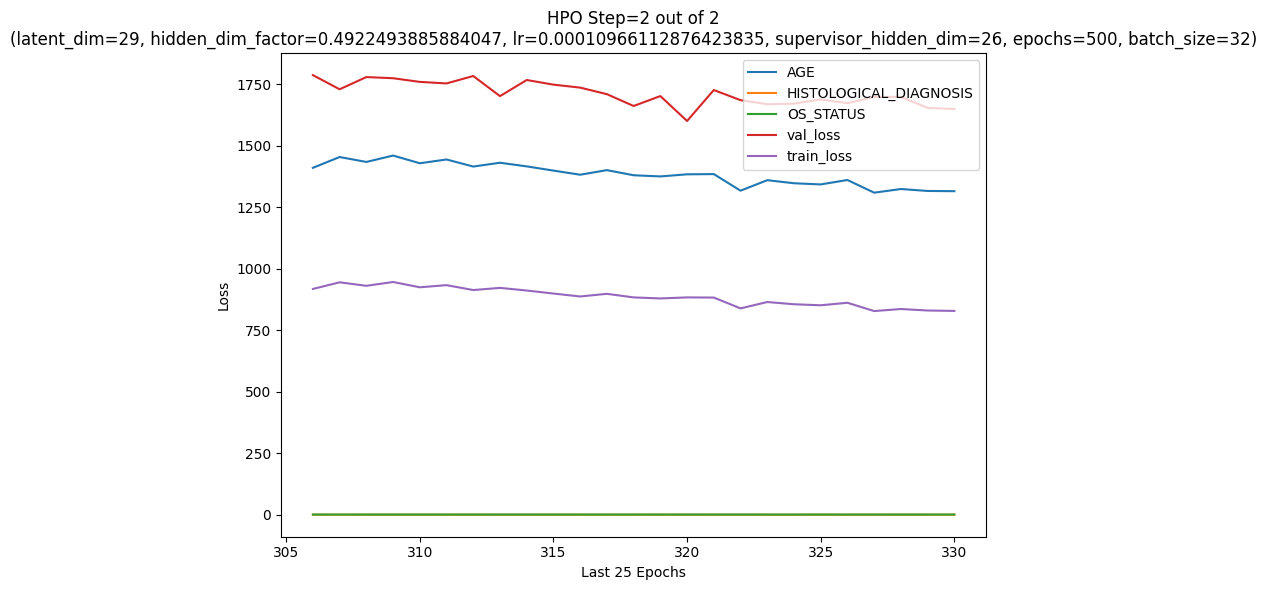

Validation: |          | 0/? [00:00<?, ?it/s]

/Users/hc/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/hc/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│            AGE            │     1646.753662109375     │
│  HISTOLOGICAL_DIAGNOSIS   │    0.9279403686523438     │
│         OS_STATUS         │    1.9626463651657104     │
│         val_loss          │    1649.6441650390625     │
└───────────────────────────┴───────────────────────────┘

Tuning Progress: 100%|██████████| 2/2 [03:36<00:00, 108.48s/it, Iteration=2, Best Loss=206]

[INFO] current best val loss: 205.6193389892578; best params: {'latent_dim': 62, 'hidden_dim_factor': 0.3268067340188569, 'lr': 0.004401623460255833, 'supervisor_hidden_dim': 8, 'epochs': 500, 'batch_size': 64} since 1 hpo iterations


{'latent_dim': 62,
 'hidden_dim_factor': 0.3268067340188569,
 'lr': 0.004401623460255833,
 'supervisor_hidden_dim': 8,
 'epochs': 85,
 'batch_size': 64}

In [24]:
tuner = flexynesis.main.HyperparameterTuning(train_dataset, 
                                        model_class = flexynesis.models.DirectPred, 
                                        config_name = "DirectPred",
                                        surv_event_var="OS_STATUS",
                                        surv_time_var="OS_MONTHS",
                                        target_variables = ['AGE', 'HISTOLOGICAL_DIAGNOSIS'], 
                                        n_iter=2, 
                                        plot_losses=True, 
                                        early_stop_patience=10)
model, best_params = tuner.perform_tuning()
best_params

In [25]:
# evaluate the model 
flexynesis.utils.evaluate_wrapper(method = 'DirectPred', y_pred_dict=model.predict(test_dataset), dataset = test_dataset, 
                            surv_event_var=model.surv_event_var, surv_time_var=model.surv_time_var)

,method,var,variable_type,metric,value
0,DirectPred,AGE,numerical,mse,200.758423
1,DirectPred,AGE,numerical,r2,0.277457
2,DirectPred,AGE,numerical,pearson_corr,0.526742
3,DirectPred,HISTOLOGICAL_DIAGNOSIS,categorical,balanced_acc,0.595955
4,DirectPred,HISTOLOGICAL_DIAGNOSIS,categorical,f1_score,0.646113
5,DirectPred,HISTOLOGICAL_DIAGNOSIS,categorical,kappa,0.524336
6,DirectPred,HISTOLOGICAL_DIAGNOSIS,categorical,average_auroc,NaN
7,DirectPred,HISTOLOGICAL_DIAGNOSIS,categorical,average_aupr,NaN
8,DirectPred,OS_STATUS,numerical,cindex,0.744334


**Conclusion**: We managed to get an improved C-index with a multi-task approach.

## 3.2 Survival-risk subtypes 

Use the best model from the above exercises to inspect sample embeddings categorized by survival risk scores. 

Let's group the samples by predicted survival risk scores into 2 groups and visualize the sample embeddings colored by risk subtypes.

**Notice**: You can use the code-below to get survival risk groups, however, notice that you must have built a model with "OS_STATUS" already. 

In [26]:
# get model outputs for survival variable 
outputs = model.predict(test_dataset)['OS_STATUS'].flatten() 
risk_scores = np.exp(outputs)
# Define quantile thresholds
quantiles = np.quantile(risk_scores, [0.5])
# Assign groups based on quantiles
groups = np.digitize(risk_scores, quantiles)

In [27]:
# Extract sample embeddings 
E = model.transform(test_dataset)

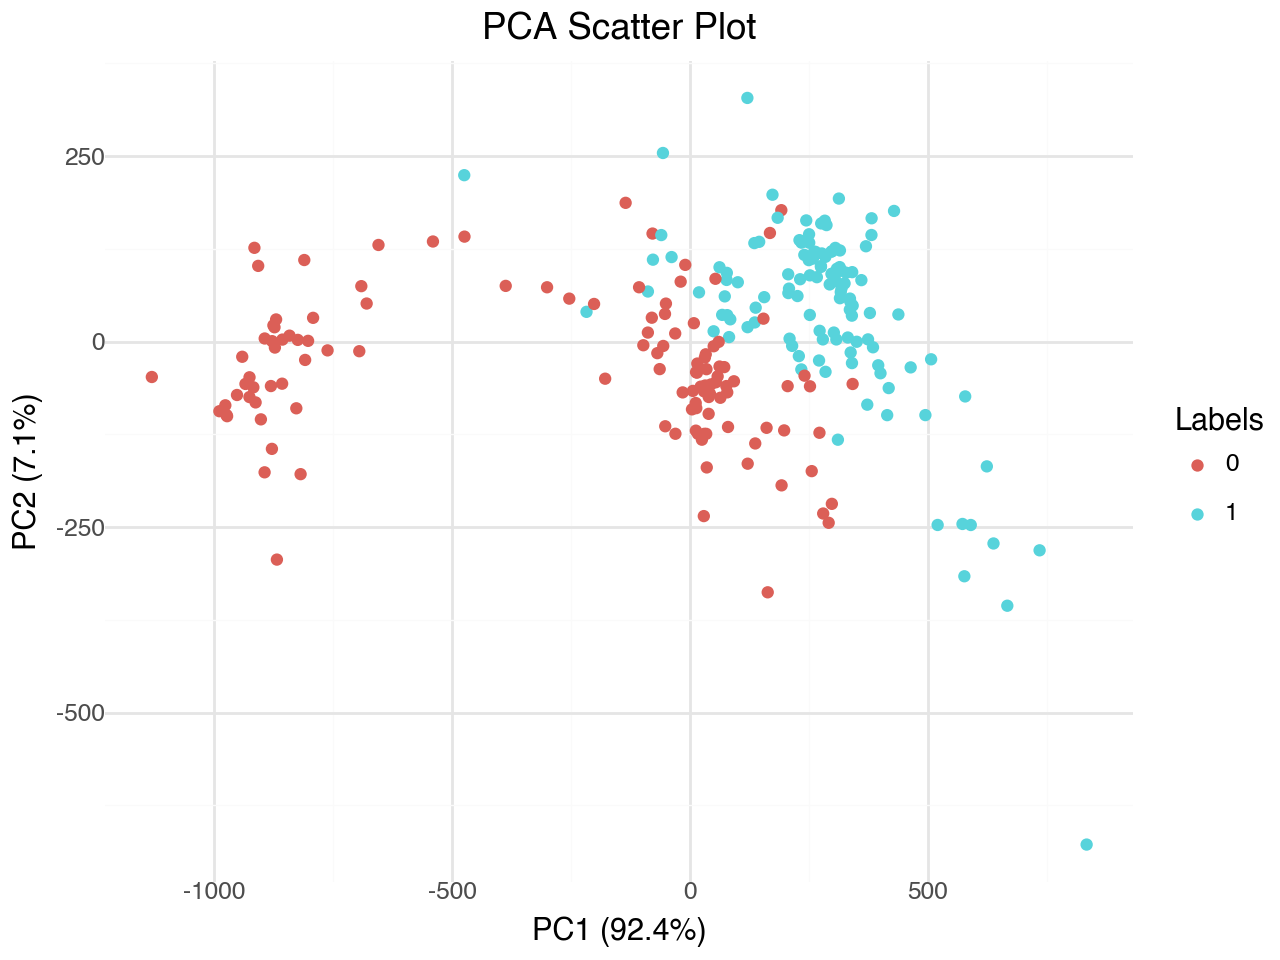

In [28]:
flexynesis.utils.plot_dim_reduced(E, groups)

Let's also see the Kaplan Meier Curves of the risk subtypes

In [29]:
# remove samples with NA values first 
durations = test_dataset.ann['OS_MONTHS']
events = test_dataset.ann['OS_STATUS']
valid_indices = ~torch.isnan(durations) & ~torch.isnan(events)

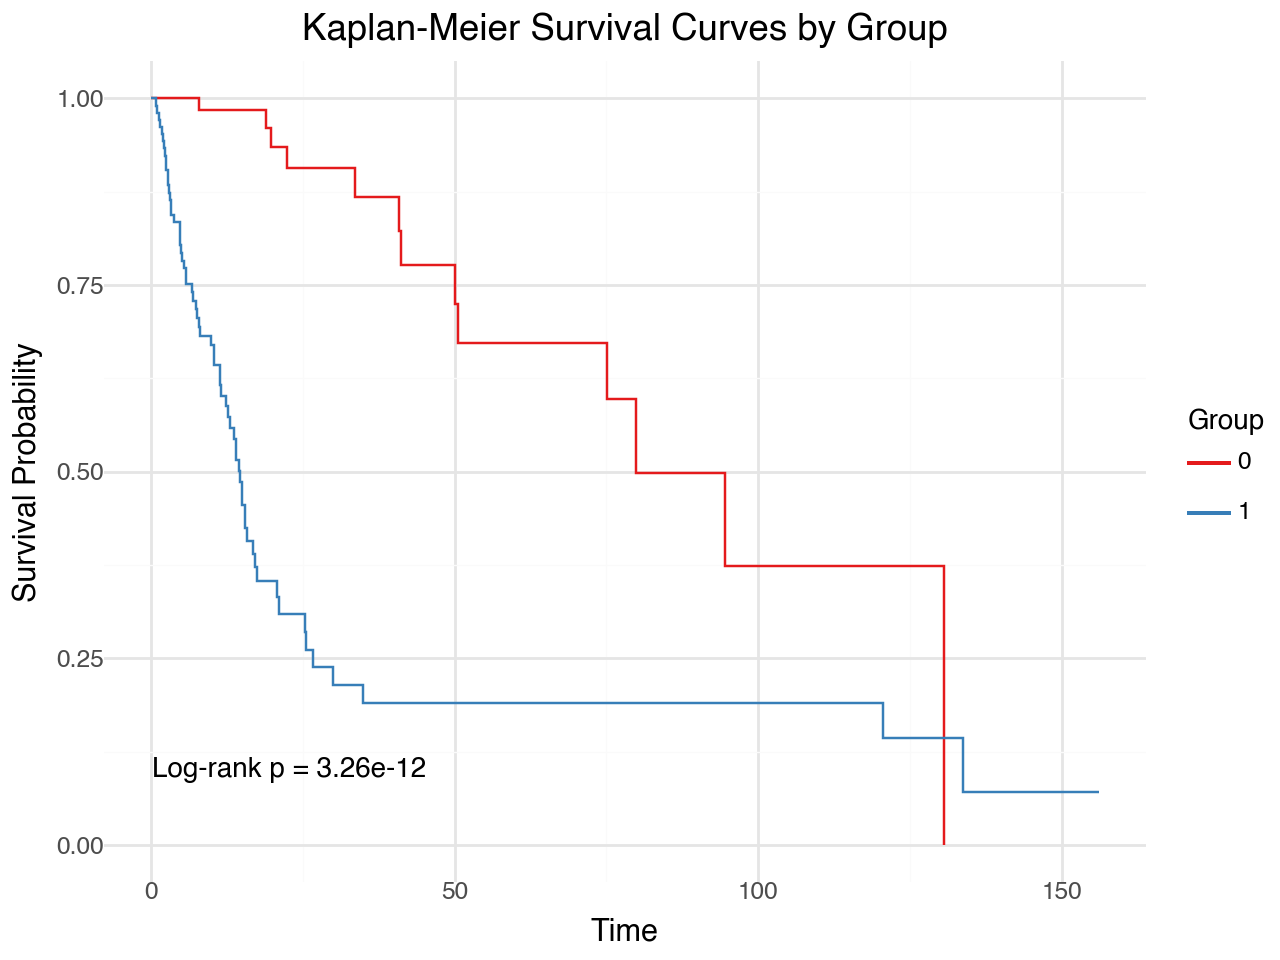

In [30]:
flexynesis.utils.plot_kaplan_meier_curves(durations[valid_indices], events[valid_indices], groups[valid_indices]) 

### Finding survival-associated markers 

We can also compute feature importance scores for prediction of overall survival. 

In [31]:
model.compute_feature_importance(train_dataset, 'OS_STATUS')

In [32]:
# get top 10 features 
flexynesis.utils.get_important_features(model, var = 'OS_STATUS', top=10)

/Users/hc/Library/Python/3.9/lib/python/site-packages/flexynesis/utils.py:842: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


,target_variable,target_class,target_class_label,layer,name,importance
0,OS_STATUS,0,,mut,IDH1,0.442029
1,OS_STATUS,0,,mut,ATRX,0.254045
2,OS_STATUS,0,,mut,TP53,0.104253
3,OS_STATUS,0,,mut,CIC,0.054035
4,OS_STATUS,0,,mut,NF1,0.046688
5,OS_STATUS,0,,cna,MIR603,0.043546
6,OS_STATUS,0,,mut,IDH2,0.038771
7,OS_STATUS,0,,mut,SVIL,0.027631
8,OS_STATUS,0,,mut,COL6A3,0.023803
9,OS_STATUS,0,,mut,BRAF,0.022532


### Comparing top markers with clinical covariates 

Let's build a linear Cox-PH model including the top 5 markers and other clinical variables such as histological diagnosis, disease type (STUDY), age, and sex. 

In [33]:
# define a data.frame with clinical covariates and top markers along with survival endpoints 
vars = ['AGE', 'SEX', 'HISTOLOGICAL_DIAGNOSIS', 'STUDY', 'OS_MONTHS', 'OS_STATUS']
# read clinical variables 
df_clin = pd.concat(
    [pd.DataFrame({x: train_dataset.ann[x] for x in vars}, index=train_dataset.samples),
     pd.DataFrame({x: test_dataset.ann[x] for x in vars}, index=test_dataset.samples)], 
    axis = 0)
# get top 5 survival markers and extract the input data for these markers for both training and test data
imp = flexynesis.utils.get_important_features(model, var = 'OS_STATUS', top=5) 
df_imp = pd.concat([train_dataset.get_feature_subset(imp), test_dataset.get_feature_subset(imp)], axis=0)  

# combine markers with clinical variables
df = pd.concat([df_imp, df_clin], axis = 1)
# remove samples without survival endpoints
df = df[df['OS_STATUS'].notna()]
df

/Users/hc/Library/Python/3.9/lib/python/site-packages/flexynesis/utils.py:842: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


,mut_IDH1,mut_ATRX,mut_TP53,mut_CIC,mut_NF1,AGE,SEX,HISTOLOGICAL_DIAGNOSIS,STUDY,OS_MONTHS,OS_STATUS
TCGA-DH-A7UU,0.982173,-0.585658,1.235829,-0.344546,-0.267004,43.0,1.0,0.0,0.0,3.400000,0.0
TCGA-06-0142,-1.018150,-0.585658,-0.809174,-0.344546,-0.267004,81.0,1.0,1.0,1.0,2.200000,1.0
TCGA-74-6584,-1.018150,-0.585658,-0.809174,-0.344546,-0.267004,55.0,0.0,1.0,1.0,7.500000,0.0
TCGA-06-0168,-1.018150,-0.585658,-0.809174,-0.344546,-0.267004,59.0,0.0,1.0,1.0,19.600000,1.0
TCGA-R8-A6ML,0.982173,-0.585658,-0.809174,2.902366,-0.267004,52.0,1.0,3.0,0.0,94.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...
TCGA-19-5950,-1.018150,-0.585658,-0.809174,-0.344546,-0.267004,52.0,0.0,1.0,1.0,11.300000,0.0
TCGA-CS-6188,-1.018150,-0.585658,-0.809174,-0.344546,-0.267004,48.0,1.0,0.0,0.0,23.799999,0.0
TCGA-DU-6406,-1.018150,-0.585658,-0.809174,-0.344546,-0.267004,59.0,0.0,2.0,0.0,16.799999,1.0
TCGA-HT-7604,0.982173,1.707482,1.235829,-0.344546,-0.267004,50.0,1.0,0.0,0.0,107.900002,0.0


In [34]:
# build a cox model
coxm = flexynesis.utils.build_cox_model(df, 'OS_MONTHS', 'OS_STATUS')

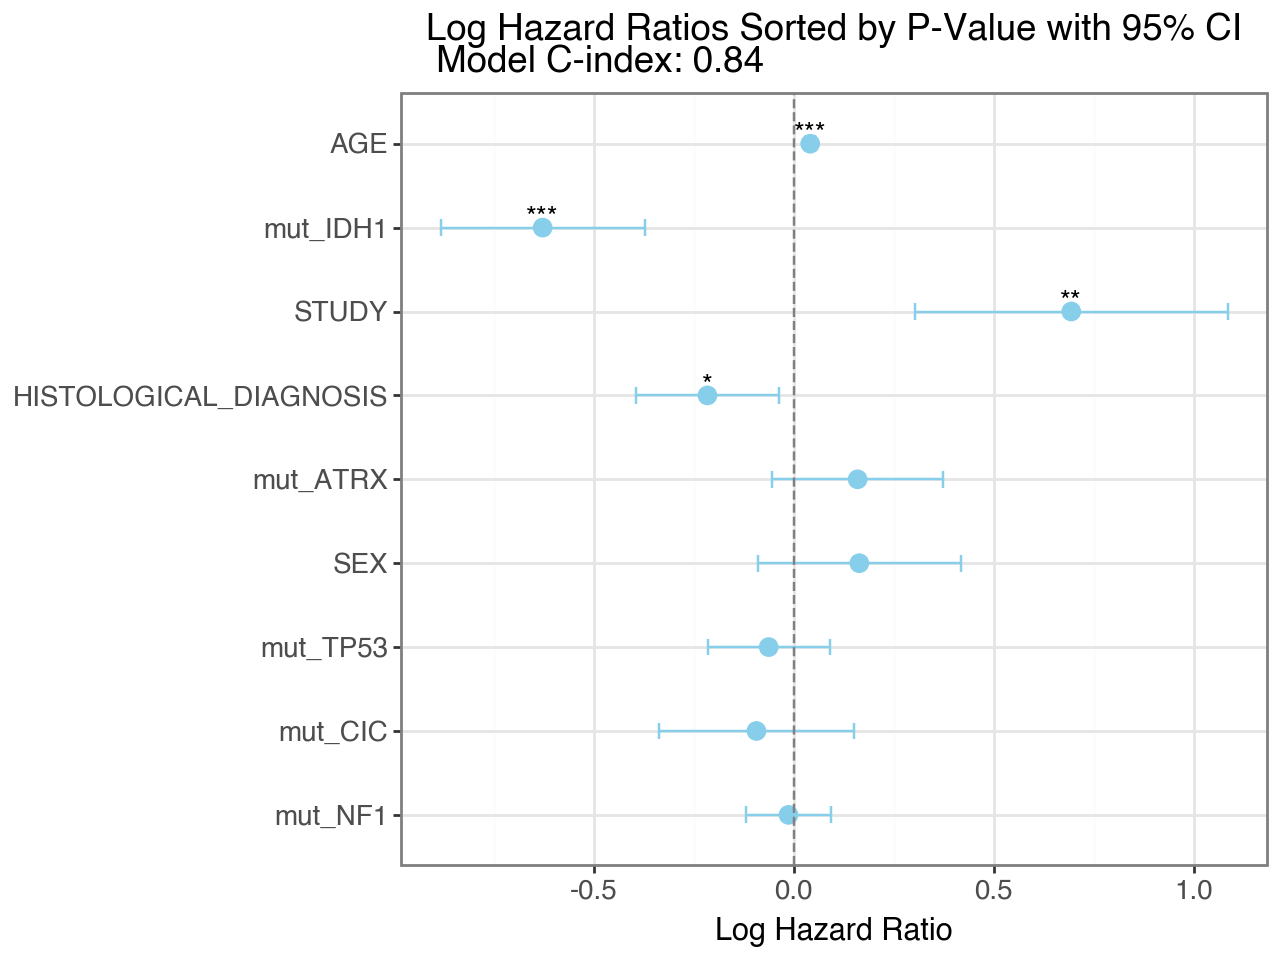

In [35]:
# visualize log-hazard ratios sorted by p-values
flexynesis.utils.plot_hazard_ratios(coxm)